In [1]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb
import numpy as np
import pandas as pd
import os
import re
import glob
import csv
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

from collections import defaultdict
from datetime import datetime
from tsfresh import extract_features as ts_extract_features

from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn import metrics
from sklearn.base import clone
from copy import deepcopy

color = sns.color_palette()

# Set global variables

In [2]:
_PATH_TO_FEATURES = "C:\\Users\\Steven\\github\\hyperaktiv\\data\\features.csv"
_PATH_TO_GT = "C:\\Users\\Steven\\github\\hyperaktiv\\data\\patient_data.csv"
_PATH_TO_ACTIVITY_DATA = "C:\\Users\\Steven\\github\\hyperaktiv\\data\\activity_data"
_RANDOM_SEED = 0
_NUMBER_OF_FOLDS = 10
_NUMBER_OF_FEATURES = 50
_TEST_RATIO = .10
_VISUALIZE_PATIENT = "C:\\Users\\Steven\\github\\hyperaktiv\\data\\activity_data\\patient_activity_57.csv"

In [3]:
_PARAMS_LORGREG = {
    "penalty": "l2", "C": 1.0, "class_weight": "balanced",
    "random_state": 0, "solver": "liblinear", "n_jobs": 1
}

_PARAMS_RFC = {
    "n_estimators": 1000, "criterion": "entropy",
    "max_features": "auto", "max_depth": None,
    "min_samples_split": 2, "min_samples_leaf": 1,
    "min_weight_fraction_leaf": 0.0,
    "max_leaf_nodes": None, "bootstrap": True,
    "oob_score": False, "n_jobs": -1, "random_state": _RANDOM_SEED,
    "class_weight": "balanced"
}

_PARAMS_XGB = {
    "nthread":16, "learning_rate": 0.3, "gamma": 0, "max_depth": 6, "verbosity": 0,
    "min_child_weight": 1, "max_delta_step": 0, "subsample": 1.0, "colsample_bytree": 1.0,
    "objective":"binary:logistic", "num_class":1, "eval_metric":"logloss", "seed": _RANDOM_SEED,
}

_PARAMS_LIGHTGB = {
    "task": "train", "num_class":1, "boosting": "gbdt", "verbosity": -1,
    "objective": "binary", "metric": "binary_logloss", "metric_freq":50, "is_training_metric":False,
    "max_depth":4, "num_leaves": 31, "learning_rate": 0.01, "feature_fraction": 1.0, "bagging_fraction": 1.0,
    "bagging_freq": 0, "bagging_seed": _RANDOM_SEED, "num_threads":16
}

# Define functions

In [4]:
def extract_features(data_dir, fc_parameters):

    def read_activity_file(filepath, patient_id):
        data = [ ]
        with open(filepath) as f:
            csv_reader = csv.reader(f, delimiter=";")
            next(csv_reader)
            for line in csv_reader:
                data.append([ datetime.strptime(line[0], "%m-%d-%Y %H:%M").timestamp(), int(line[1].split(" ")[0])])
        data = pd.DataFrame(data, columns=["TIME", "ACC"])
        data["ID"] = patient_id
        return data

    patient_records = []

    for filepath in glob.glob(os.path.join(data_dir, "*.csv")):
        patient_id = int(os.path.splitext(os.path.basename(filepath))[0].split("_")[-1])
        data = read_activity_file(filepath, patient_id)
        patient_records.append(data)

    patient_records = pd.concat(patient_records)

    dataX = ts_extract_features(patient_records, default_fc_parameters=fc_parameters, column_id="ID", column_value="ACC", column_sort="TIME", n_jobs=0, show_warnings=False)
    dataX['ID'] = dataX.index
    return dataX

In [5]:
def find_most_important_features(x_data, y_data, n_features):

    model = LogisticRegression()
    model.fit(x_data, y_data)
    importances = pd.DataFrame(data={
        'Attribute': dataX.columns,
        'Importance': model.coef_[0]
    })
    importances = importances.sort_values(by='Importance', ascending=False)[:n_features]
    # print(importances)
    most_important_features = defaultdict(list)
    
    for feature in importances["Attribute"].values:
        
        feature_attributes = feature.split("__")
        
        feature_params = {}
        
        for feature_attribute in feature_attributes[2:]:
            feature_key, feature_val = feature_attribute.split("_")
            
            try:
                feature_val = int(feature_val)
            except:
                pass
            
            feature_params[feature_key] = feature_val
        most_important_features[feature_attributes[1]].append(feature_params)

    print(dict(most_important_features))
            
    plt.bar(x=importances['Attribute'], height=importances['Importance'], color='#087E8B')
    plt.title('Feature importances obtained from coefficients', size=20)
    plt.xticks(rotation='vertical')
    plt.show()
    
    return most_important_features

In [6]:
def clean_data(x_data, y_data):
    x_data = x_data.fillna(0)

    x_data = x_data.rename(columns = lambda x:re.sub('"', '', x))
    x_data = x_data.rename(columns = lambda x:re.sub(',', '', x))
    y_data = y_data.rename(columns = lambda x:re.sub('"', '', x))
    y_data = y_data.rename(columns = lambda x:re.sub(',', '', x))
    
    return x_data, y_data

# Visualize the dataset

In [7]:
dataX = pd.read_csv(_PATH_TO_FEATURES, sep=";").sort_values(by="ID")
dataY = pd.read_csv(_PATH_TO_GT, sep=";").sort_values(by="ID")
dataY.columns

Index(['ID', 'SEX', 'AGE', 'ACC', 'ACC_TIME', 'ACC_DAYS', 'HRV', 'HRV_TIME',
       'HRV_HOURS', 'CPT_II', 'ADHD', 'ADD', 'BIPOLAR', 'UNIPOLAR', 'ANXIETY',
       'SUBSTANCE', 'OTHER', 'CT', 'MDQ_POS', 'WURS', 'ASRS', 'MADRS',
       'HADS_A', 'HADS_D', 'MED', 'MED_Antidepr', 'MED_Moodstab',
       'MED_Antipsych', 'MED_Anxiety_Benzo', 'MED_Sleep',
       'MED_Analgesics_Opioids', 'MED_Stimulants', 'filter_$'],
      dtype='object')

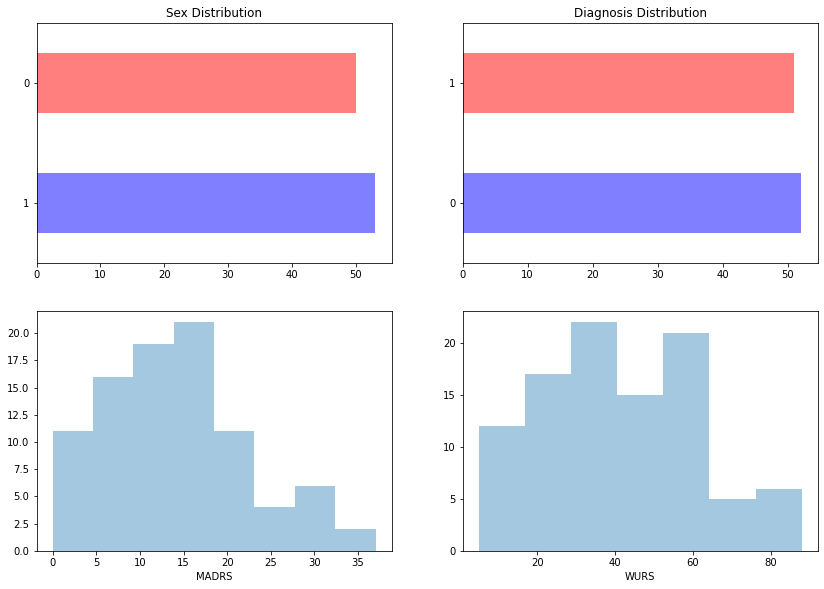

In [8]:
fig = plt.figure(figsize=(14,15))

ax2 = fig.add_subplot(321)
ax2 = dataY['SEX'].value_counts().plot(kind='barh', color=['blue','red'], alpha=.5,
                                                  title='Sex Distribution')
ax3 = fig.add_subplot(322)
ax3 = dataY['ADHD'].value_counts().plot(kind='barh', color=['blue','red', 'green'], alpha=.5,
                                                  title='Diagnosis Distribution')
ax5 = fig.add_subplot(323)
ax5 = sns.distplot(dataY['MADRS'], kde=False)

ax5 = fig.add_subplot(324)
ax5 = sns.distplot(dataY['WURS'], kde=False)

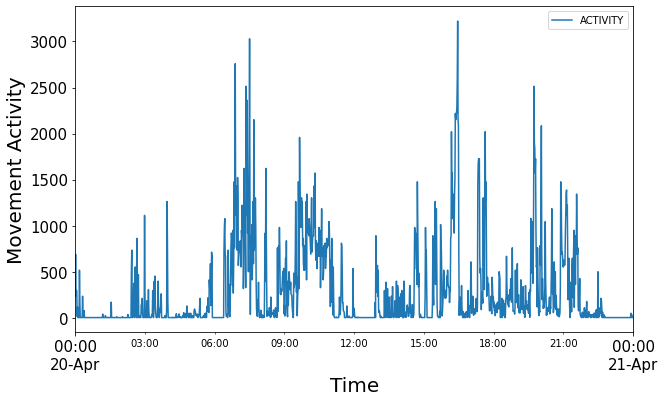

In [9]:
patient_activity_data = pd.read_csv(_VISUALIZE_PATIENT, sep=";", parse_dates=["TIMESTAMP"], infer_datetime_format=True).sort_values(by="TIMESTAMP")
patient_activity_data = patient_activity_data.set_index(['TIMESTAMP'])

patient_activity_data.loc['2010-04-20 00:00:00':'2010-04-21 00:00:00'].plot(kind='line', figsize=(10,6))

plt.xlabel('Time',size=20); plt.xticks(size=15)
plt.ylabel('Movement Activity',size=20); plt.yticks(size=15)

plt.show()

# Find most important features

C:\Users\Steven\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


{'spkt_welch_density': [{'coeff': 5}], 'fft_coefficient': [{'attr': 'real', 'coeff': 7}, {'attr': 'imag', 'coeff': 6}, {'attr': 'real', 'coeff': 56}, {'attr': 'real', 'coeff': 21}, {'attr': 'real', 'coeff': 55}, {'attr': 'real', 'coeff': 51}, {'attr': 'abs', 'coeff': 22}, {'attr': 'abs', 'coeff': 8}, {'attr': 'real', 'coeff': 37}, {'attr': 'abs', 'coeff': 29}, {'attr': 'abs', 'coeff': 12}, {'attr': 'imag', 'coeff': 4}, {'attr': 'real', 'coeff': 79}, {'attr': 'imag', 'coeff': 44}, {'attr': 'abs', 'coeff': 7}, {'attr': 'imag', 'coeff': 43}, {'attr': 'real', 'coeff': 29}, {'attr': 'imag', 'coeff': 15}, {'attr': 'real', 'coeff': 25}, {'attr': 'real', 'coeff': 84}, {'attr': 'abs', 'coeff': 28}, {'attr': 'abs', 'coeff': 15}, {'attr': 'real', 'coeff': 61}, {'attr': 'real', 'coeff': 74}, {'attr': 'real', 'coeff': 20}, {'attr': 'real', 'coeff': 41}, {'attr': 'real', 'coeff': 77}, {'attr': 'real', 'coeff': 10}, {'attr': 'real', 'coeff': 32}, {'attr': 'imag', 'coeff': 96}, {'attr': 'real', 'coeff

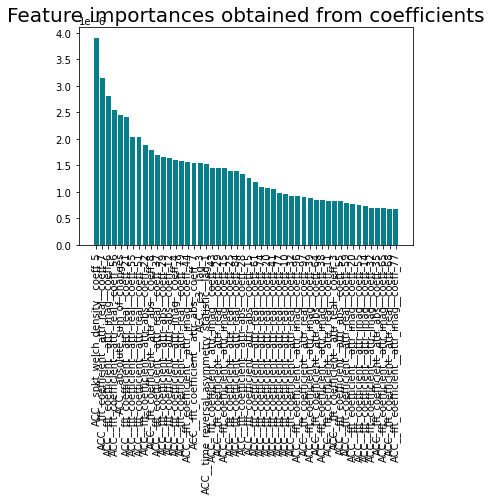

In [10]:
dataX = pd.read_csv(_PATH_TO_FEATURES, sep=";").sort_values(by="ID")
dataY = pd.read_csv(_PATH_TO_GT, sep=";").sort_values(by="ID")

dataX, dataY = clean_data(dataX, dataY)

dataY = dataY[dataY["ID"].isin(dataX["ID"])]
dataX = dataX[dataX["ID"].isin(dataY["ID"])]

dataX = dataX.drop(["ID"], axis = 1)

dataY = dataY["ADHD"]

X_TRAIN, X_TEST, Y_TRAIN, Y_TEST = train_test_split(
    dataX,
    dataY,
    test_size=_TEST_RATIO,
    random_state=_RANDOM_SEED,
    stratify=dataY)

important_feature_params = find_most_important_features(X_TRAIN, Y_TRAIN, _NUMBER_OF_FEATURES)

# Prepare data using most important features

In [11]:
dataX = extract_features(_PATH_TO_ACTIVITY_DATA, important_feature_params).sort_values(by="ID")
dataY = pd.read_csv(_PATH_TO_GT, sep=";").sort_values(by="ID")

dataX, dataY = clean_data(dataX, dataY)

dataY = dataY[dataY["ID"].isin(dataX["ID"])]
dataX = dataX[dataX["ID"].isin(dataY["ID"])]

dataX = dataX.drop(["ID"], axis = 1)

dataY = dataY["ADHD"]

X_TRAIN, X_TEST, Y_TRAIN, Y_TEST = train_test_split(
    dataX,
    dataY,
    test_size=_TEST_RATIO,
    random_state=_RANDOM_SEED,
    stratify=dataY)

Feature Extraction: 100%|███████████████████████████████████████████████████████████| 116/116 [00:00<00:00, 394.60it/s]


In [12]:
def plot_au_curves(k_fold_results):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    precision = dict()
    recall = dict()
    average_precision = dict()

    all_preds = []
    all_trues = []

    for i, (y_pred, y_true) in enumerate(k_fold_results):
        fpr[i], tpr[i], _ = metrics.roc_curve(y_true, y_pred)
        roc_auc[i] = metrics.auc(fpr[i], tpr[i])
        precision[i], recall[i], _ = metrics.precision_recall_curve(y_true, y_pred)
        average_precision[i] = metrics.average_precision_score(y_true, y_pred)
        all_preds.extend(y_pred)
        all_trues.extend(y_true)

    fpr["mean"], tpr["mean"], _ = metrics.roc_curve(all_trues, all_preds)
    roc_auc['mean'] = metrics.auc(fpr['mean'], tpr['mean'])
    precision["mean"], recall["mean"], _ = metrics.precision_recall_curve(all_trues, all_preds)
    average_precision['mean'] = metrics.average_precision_score(all_trues, all_preds)


    fig = plt.figure(figsize=(18,6))

    # auroc
    ax1 = fig.add_subplot(121)

    ax1.plot([0, 1], [0, 1], linestyle='--', lw=4, color='r',
            label='Chance', alpha=.8)

    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
              '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

    # for i in range(len(k_fold_results)):
    #     ax1.plot(fpr[i], tpr[i], color=colors[i],
    #         label=r'ROC Fold %i (AUC = %0.2f)' % (i+1,roc_auc[i]),
    #         lw=3, alpha=.5)

    ax1.plot(fpr['mean'], tpr['mean'], color='b',
            label=r'Mean ROC (AUC = %0.2f)' % (roc_auc['mean']),
            lw=4, alpha=.8)    

    ax1.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05])
    # plt.title("Receiver Operating Characteristic Curve", size=20)
    plt.xlabel('False Positive Rate',size=20); plt.xticks(size=15)
    plt.ylabel('True Positive Rate',size=20); plt.yticks(size=15)
    ax1.legend(loc="lower right",prop={"size":15})

    # auprc
    ax2 = fig.add_subplot(122)

    # for i in range(len(k_fold_results)):
    #     ax2.step(recall[i], precision[i], where='post', color=colors[i],
    #              label=r'AP Fold %i (AP = %0.2f)' % (i+1,average_precision[i]),
    #              lw=3, alpha=.5)

    ax2.step(recall['mean'], precision['mean'], where='post', color='b',
            label=r'Mean AP (AP = %0.2f)' % (average_precision['mean']),
            lw=4, alpha=.8)    

    ax2.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05])
    # plt.title("Precision Recall Curve", size=20)
    plt.xlabel('Recall',size=20); plt.xticks(size=15)
    plt.ylabel('Precision',size=20); plt.yticks(size=15)
    ax2.legend(loc="lower left",prop={"size":15})
    
    
    extent = ax1.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    bbox = extent.expanded(1.3, 1.3)
    bbox.x1 *= 0.95
    fig.savefig('ax1_figure.png', bbox_inches=bbox)
    
    extent = ax2.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    bbox = extent.expanded(1.3, 1.3)
    bbox.x1 *= 0.95
    fig.savefig('ax2_figure_expanded.png', bbox_inches=bbox)

    plt.show()

In [13]:
def k_fold_model_evaluation( train_func, pred_func, model=None, n_splits=_NUMBER_OF_FOLDS, shuffle=True, random_state=_RANDOM_SEED ):

    y_preds, y_trues = [], []

    k_fold = StratifiedKFold(
        n_splits=n_splits,
        shuffle=shuffle,
        random_state=random_state)

    models = [ ]
    k_fold_results = [ ]

    for train_index, fold_index in k_fold.split(np.zeros(len(X_TRAIN)), Y_TRAIN.ravel()):
        
        x_fold_train, x_fold_test = X_TRAIN.iloc[train_index, :], X_TRAIN.iloc[fold_index, :]
        y_fold_train, y_fold_test = Y_TRAIN.iloc[train_index], Y_TRAIN.iloc[fold_index]

        model = train_func( model, x_fold_train, y_fold_train, x_fold_test, y_fold_test )
        models.append( deepcopy(model) )

        y_pred = pred_func( model, x_fold_test )
        
        print(np.round(y_pred), y_fold_test)
        
        k_fold_results.append((list(y_pred), list(y_fold_test)))
    
    return models, np.array(k_fold_results)

In [14]:
def cv_confusion_matrix(k_fold_results, average=True):
    cm = np.zeros((2,2))
    for fold_index, (y_pred, y_true) in enumerate(k_fold_results):
        y_pred = np.round(y_pred)
        cm += metrics.confusion_matrix(y_true, y_pred)
    if average:
        return cm / len(k_fold_results)
    return cm

In [15]:
def calculate_cv_results(cv_results):
    cv_metrics = defaultdict(list)
    for fold_index, fold_results in enumerate(cv_results):
        y_preds, y_trues = fold_results
        y_preds = np.round(np.array(y_preds, dtype=np.float32))
        cv_metrics["Fold"].append("Fold %i" % fold_index)
        cv_metrics["Accuracy"].append(metrics.accuracy_score(y_trues, y_preds))
        cv_metrics["Precision"].append(metrics.precision_score(y_trues, y_preds, average="binary"))
        cv_metrics["Recall"].append(metrics.recall_score(y_trues, y_preds, average="binary"))
        cv_metrics["F1-Score"].append(metrics.f1_score(y_trues, y_preds, average="binary"))
        cv_metrics["MCC"].append(metrics.matthews_corrcoef(y_trues, y_preds))
    return pd.DataFrame(data=dict(cv_metrics))

# Logistic Regression

In [16]:
def train_func(model, x_train, y_train, x_test, y_test):
    model.fit(x_train, y_train)
    return model
def pred_func(model, data):
    return model.predict_proba(data)[:, 1]
model = LogisticRegression( **_PARAMS_LORGREG )
models, k_fold_results = k_fold_model_evaluation( train_func, pred_func, model )

[0. 1. 0. 1. 0. 1. 1. 1.] 61     0
78     0
0      1
40     1
83     1
102    1
32     0
76     0
Name: ADHD, dtype: int64
[1. 0. 0. 1. 1. 1. 0. 1.] 46    1
43    0
35    0
68    1
54    1
6     1
20    0
31    0
Name: ADHD, dtype: int64
[0. 0. 1. 0. 1. 1. 0. 0.] 50    0
21    0
89    0
18    1
87    1
9     1
64    1
8     0
Name: ADHD, dtype: int64
[0. 0. 0. 0. 0. 0. 0. 0.] 97    0
17    1
45    1
56    1
36    0
7     0
58    0
91    1
Name: ADHD, dtype: int64
[0. 1. 1. 1. 1. 0. 0. 0.] 85     0
55     1
69     1
100    0
80     1
44     0
41     0
4      1
Name: ADHD, dtype: int64
[1. 0. 1. 1. 0. 0. 1. 0.] 34    0
29    0
94    1
71    1
65    1
1     1
16    0
47    0
Name: ADHD, dtype: int64
[1. 0. 0. 0. 0. 0. 1.] 52    1
42    1
88    1
92    0
81    1
67    0
75    0
Name: ADHD, dtype: int64
[1. 1. 0. 1. 1. 1. 1.] 11    1
24    1
39    0
22    0
86    0
93    1
62    1
Name: ADHD, dtype: int64
[1. 1. 1. 1. 0. 1. 0.] 79    0
30    0
49    1
2     1
12    1
25    0
38    1
Name: A

## Validation Evaluation

In [17]:
np.round(k_fold_results[2][0])

array([0., 0., 1., 0., 1., 1., 0., 0.])

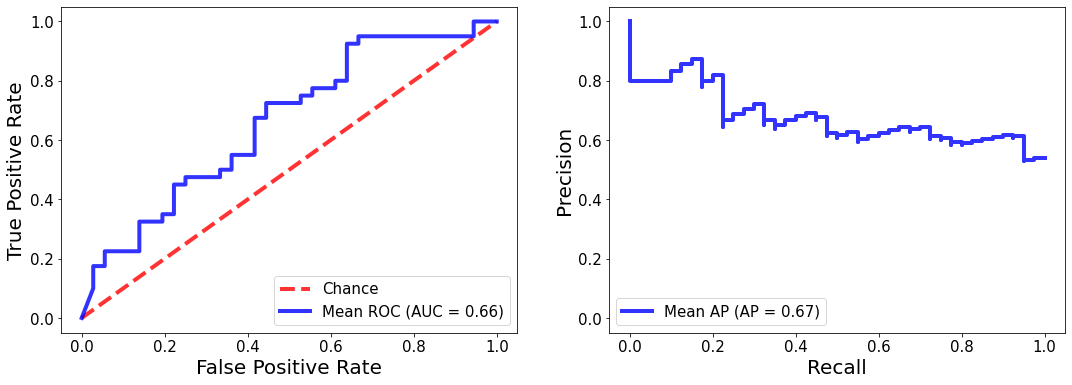

In [18]:
plot_au_curves(k_fold_results)

In [19]:
cv_confusion_matrix(k_fold_results, average=False)

array([[21., 15.],
       [16., 24.]])

## Test Evaluation

In [20]:
test_cv_results = []
for model in models:
    print(np.round(pred_func( model, X_TEST )))
    test_cv_results.append((pred_func( model, X_TEST ), list(Y_TEST)))

[1. 0. 1. 1. 0. 1. 0. 0. 1.]
[1. 0. 1. 1. 0. 1. 0. 0. 1.]
[0. 0. 1. 1. 0. 1. 0. 0. 1.]
[1. 0. 1. 1. 0. 0. 0. 0. 1.]
[1. 0. 0. 1. 0. 1. 0. 0. 1.]
[1. 0. 1. 1. 0. 1. 0. 0. 1.]
[1. 0. 1. 1. 0. 1. 0. 0. 1.]
[0. 0. 1. 1. 0. 1. 0. 0. 1.]
[0. 0. 1. 1. 0. 1. 0. 0. 1.]
[1. 0. 1. 1. 0. 1. 0. 0. 1.]


In [21]:
np.round(test_cv_results[0])

array([[1., 0., 1., 1., 0., 1., 0., 0., 1.],
       [1., 0., 1., 0., 0., 1., 0., 1., 1.]])

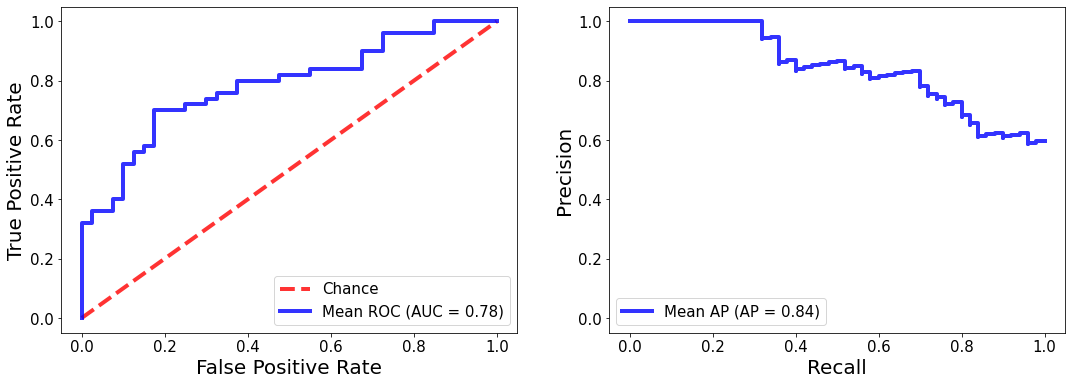

In [22]:
plot_au_curves(test_cv_results)

In [23]:
calculate_cv_results(test_cv_results)

,Fold,Accuracy,Precision,Recall,F1-Score,MCC
0,Fold 0,0.777778,0.80,0.8,0.800000,0.55
1,Fold 1,0.777778,0.80,0.8,0.800000,0.55
2,Fold 2,0.666667,0.75,0.6,0.666667,0.35
3,Fold 3,0.666667,0.75,0.6,0.666667,0.35
4,Fold 4,0.666667,0.75,0.6,0.666667,0.35
5,Fold 5,0.777778,0.80,0.8,0.800000,0.55
6,Fold 6,0.777778,0.80,0.8,0.800000,0.55
7,Fold 7,0.666667,0.75,0.6,0.666667,0.35
8,Fold 8,0.666667,0.75,0.6,0.666667,0.35
9,Fold 9,0.777778,0.80,0.8,0.800000,0.55


In [24]:
cv_confusion_matrix(test_cv_results)

array([[3. , 1. ],
       [1.5, 3.5]])

# Random Forest

In [25]:
def train_func(model, x_train, y_train, x_test, y_test):
    model.fit(x_train, y_train)
    return model
def pred_func(model, data):
    return model.predict_proba(data)[:, 1]
model = RandomForestClassifier( **_PARAMS_RFC )
models, k_fold_results = k_fold_model_evaluation( train_func, pred_func, model )

[0. 1. 1. 1. 0. 1. 1. 1.] 61     0
78     0
0      1
40     1
83     1
102    1
32     0
76     0
Name: ADHD, dtype: int64
[1. 0. 0. 1. 1. 1. 0. 1.] 46    1
43    0
35    0
68    1
54    1
6     1
20    0
31    0
Name: ADHD, dtype: int64
[0. 0. 1. 1. 1. 1. 0. 0.] 50    0
21    0
89    0
18    1
87    1
9     1
64    1
8     0
Name: ADHD, dtype: int64
[1. 1. 1. 0. 1. 0. 0. 1.] 97    0
17    1
45    1
56    1
36    0
7     0
58    0
91    1
Name: ADHD, dtype: int64
[0. 1. 1. 1. 1. 1. 1. 0.] 85     0
55     1
69     1
100    0
80     1
44     0
41     0
4      1
Name: ADHD, dtype: int64
[1. 0. 0. 1. 1. 0. 0. 0.] 34    0
29    0
94    1
71    1
65    1
1     1
16    0
47    0
Name: ADHD, dtype: int64
[1. 0. 0. 0. 1. 0. 0.] 52    1
42    1
88    1
92    0
81    1
67    0
75    0
Name: ADHD, dtype: int64
[1. 1. 0. 1. 1. 1. 1.] 11    1
24    1
39    0
22    0
86    0
93    1
62    1
Name: ADHD, dtype: int64
[0. 1. 1. 1. 1. 1. 0.] 79    0
30    0
49    1
2     1
12    1
25    0
38    1
Name: A

## Validation Evaluation

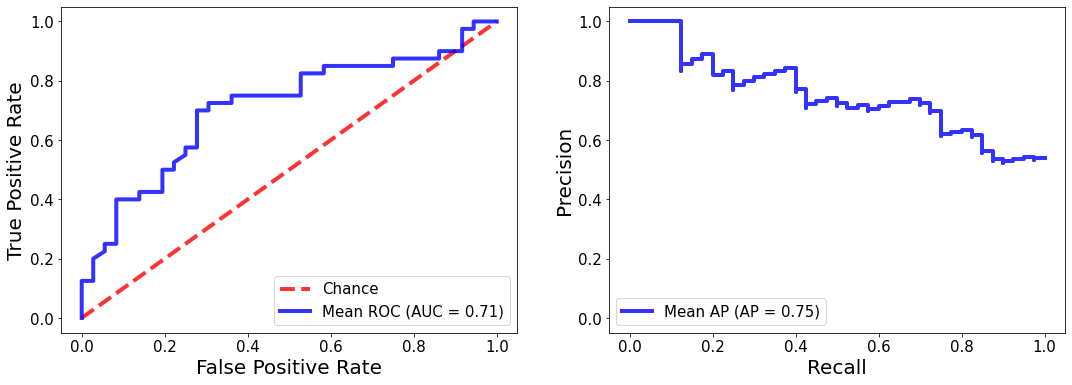

In [26]:
plot_au_curves(k_fold_results)

## Test Evaluation

In [27]:
test_cv_results = []
for model in models:
    test_cv_results.append((pred_func( model, X_TEST ), list(Y_TEST)))

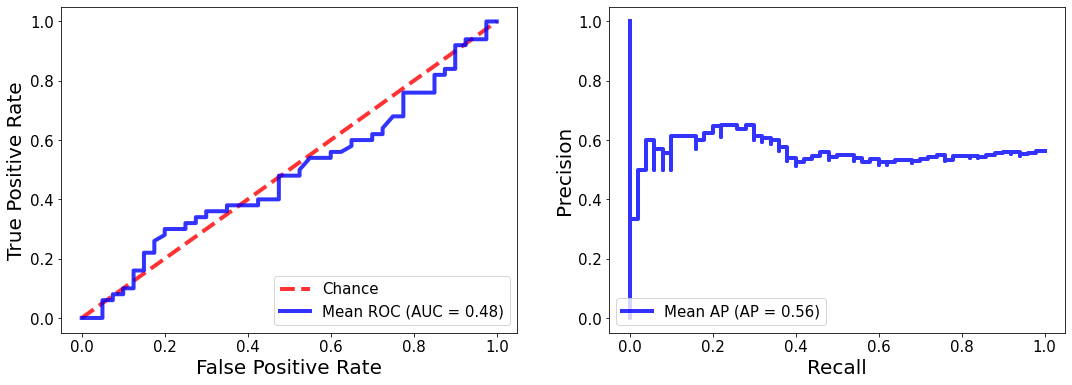

In [28]:
plot_au_curves(test_cv_results)

In [29]:
calculate_cv_results(test_cv_results)

,Fold,Accuracy,Precision,Recall,F1-Score,MCC
0,Fold 0,0.444444,0.500000,0.6,0.545455,-0.158114
1,Fold 1,0.555556,0.571429,0.8,0.666667,0.059761
2,Fold 2,0.444444,0.500000,0.6,0.545455,-0.158114
3,Fold 3,0.555556,0.600000,0.6,0.600000,0.100000
4,Fold 4,0.444444,0.500000,0.6,0.545455,-0.158114
5,Fold 5,0.444444,0.500000,0.6,0.545455,-0.158114
6,Fold 6,0.555556,0.600000,0.6,0.600000,0.100000
7,Fold 7,0.444444,0.500000,0.6,0.545455,-0.158114
8,Fold 8,0.555556,0.600000,0.6,0.600000,0.100000
9,Fold 9,0.333333,0.400000,0.4,0.400000,-0.350000


# XGBoost

In [43]:
def train_func(model, x_train, y_train, x_test, y_test):
    model = xgb.XGBClassifier()
    bst = model.fit(x_train, y_train)
    return bst
def pred_func(model, data):
#     data = xgb.DMatrix(data=data)
    pred = model.predict(data)
    return pred
models, k_fold_results = k_fold_model_evaluation( train_func, pred_func )

C:\Users\Steven\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Steven\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[0 1 1 1 0 1 0 0] 61     0
78     0
0      1
40     1
83     1
102    1
32     0
76     0
Name: ADHD, dtype: int64
[1 1 0 1 1 1 0 1] 46    1
43    0
35    0
68    1
54    1
6     1
20    0
31    0
Name: ADHD, dtype: int64
[0 0 1 0 1 0 1 0] 50    0
21    0
89    0
18    1
87    1
9     1
64    1
8     0
Name: ADHD, dtype: int64
[1 1 1 0 0 0 0 1] 97    0
17    1
45    1
56    1
36    0
7     0
58    0
91    1
Name: ADHD, dtype: int64
[1 1 1 1 1 1 1 0] 85     0
55     1
69     1
100    0
80     1
44     0
41     0
4      1
Name: ADHD, dtype: int64
[1 0 0 1 1 0 0 0] 34    0
29    0
94    1
71    1
65    1
1     1
16    0
47    0
Name: ADHD, dtype: int64
[1 0 0 0 1 0 1] 52    1
42    1
88    1
92    0
81    1
67    0
75    0
Name: ADHD, dtype: int64
[0 1 0 1 1 1 1] 11    1
24    1
39    0
22    0
86    0
93    1
62    1
Name: ADHD, dtype: int64
[1 0 1 1 0 1 1] 79    0
30    0
49    1
2     1
12    1
25    0
38    1
Name: ADHD, dtype: int64
[1 1 0 0 1 1 0] 60    1
90    1
48    1
53    0
70 

## Validation Evaluation

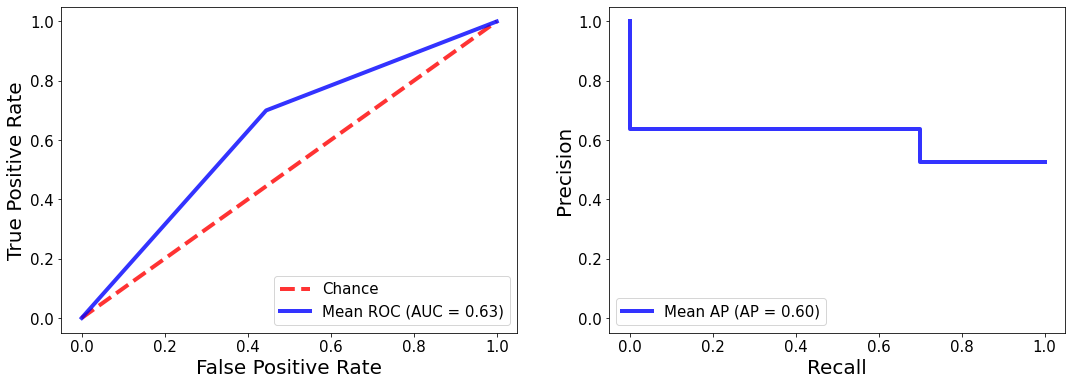

In [44]:
plot_au_curves(k_fold_results)

## Test Evaluation

In [45]:
test_cv_results = []
for model in models:
    test_cv_results.append((pred_func( model, X_TEST ), list(Y_TEST)))

C:\Users\Steven\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


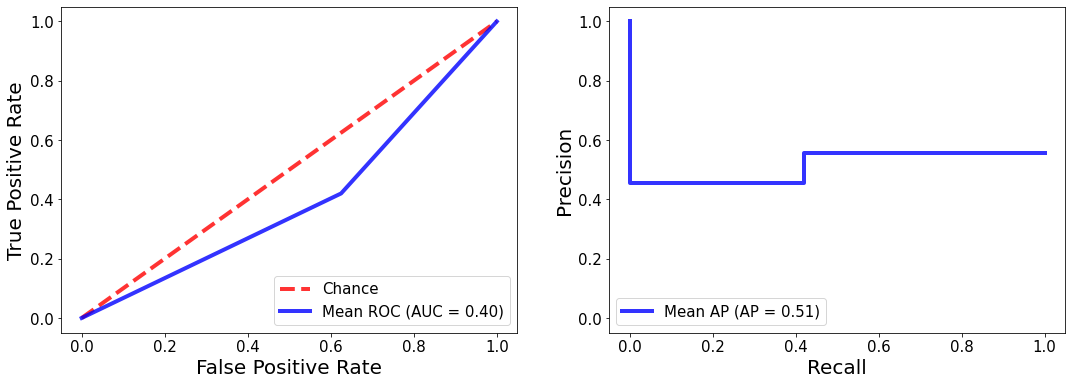

In [46]:
plot_au_curves(test_cv_results)

In [47]:
calculate_cv_results(test_cv_results)

,Fold,Accuracy,Precision,Recall,F1-Score,MCC
0,Fold 0,0.222222,0.250000,0.2,0.222222,-0.550000
1,Fold 1,0.222222,0.250000,0.2,0.222222,-0.550000
2,Fold 2,0.555556,0.666667,0.4,0.500000,0.158114
3,Fold 3,0.555556,0.600000,0.6,0.600000,0.100000
4,Fold 4,0.444444,0.500000,0.6,0.545455,-0.158114
5,Fold 5,0.444444,0.500000,0.6,0.545455,-0.158114
6,Fold 6,0.444444,0.500000,0.6,0.545455,-0.158114
7,Fold 7,0.333333,0.400000,0.4,0.400000,-0.350000
8,Fold 8,0.444444,0.500000,0.4,0.444444,-0.100000
9,Fold 9,0.333333,0.333333,0.2,0.250000,-0.316228


# LightGBM

In [35]:
def train_func(model, x_train, y_train, x_test, y_test):
    lgb_train = lgb.Dataset(x_train, y_train)
    lgb_eval = lgb.Dataset(x_test, y_test, reference=lgb_train)
    gbm = lgb.train(_PARAMS_LIGHTGB, lgb_train)
    return gbm
def pred_func(model, data):
    return model.predict(data, num_iteration=model.best_iteration)
models, k_fold_results = k_fold_model_evaluation( train_func, pred_func )

Finished loading model, total used 100 iterations
[1. 1. 1. 1. 0. 1. 0. 0.] 61     0
78     0
0      1
40     1
83     1
102    1
32     0
76     0
Name: ADHD, dtype: int64
Finished loading model, total used 100 iterations
[1. 1. 0. 0. 1. 1. 0. 1.] 46    1
43    0
35    0
68    1
54    1
6     1
20    0
31    0
Name: ADHD, dtype: int64
Finished loading model, total used 100 iterations
[0. 0. 1. 1. 1. 1. 1. 0.] 50    0
21    0
89    0
18    1
87    1
9     1
64    1
8     0
Name: ADHD, dtype: int64
Finished loading model, total used 100 iterations
[1. 1. 0. 0. 1. 0. 0. 1.] 97    0
17    1
45    1
56    1
36    0
7     0
58    0
91    1
Name: ADHD, dtype: int64
Finished loading model, total used 100 iterations
[1. 1. 1. 1. 1. 1. 1. 0.] 85     0
55     1
69     1
100    0
80     1
44     0
41     0
4      1
Name: ADHD, dtype: int64
Finished loading model, total used 100 iterations
[1. 0. 1. 1. 1. 0. 1. 1.] 34    0
29    0
94    1
71    1
65    1
1     1
16    0
47    0
Name: ADHD, dtype: 

## Validation Evaluation

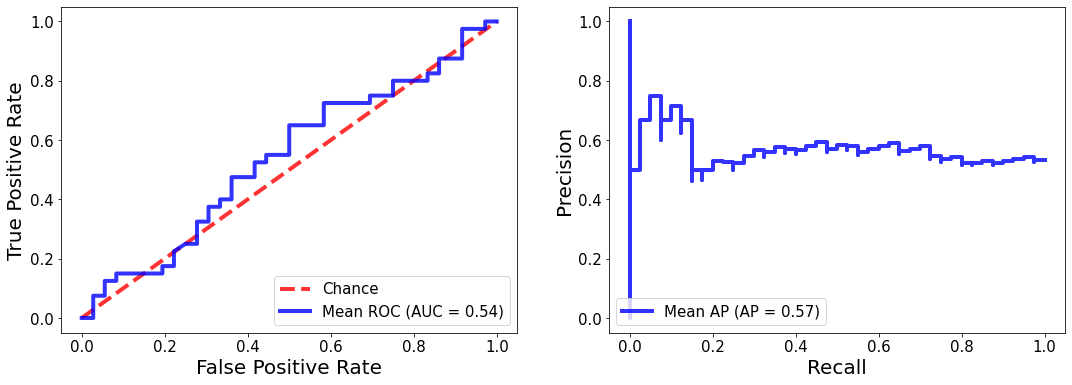

In [36]:
plot_au_curves(k_fold_results)

In [37]:
calculate_cv_results(k_fold_results)

,Fold,Accuracy,Precision,Recall,F1-Score,MCC
0,Fold 0,0.625000,0.600000,0.75,0.666667,0.258199
1,Fold 1,0.625000,0.600000,0.75,0.666667,0.258199
2,Fold 2,0.875000,0.800000,1.00,0.888889,0.774597
3,Fold 3,0.500000,0.500000,0.50,0.500000,0.000000
4,Fold 4,0.375000,0.428571,0.75,0.545455,-0.377964
5,Fold 5,0.500000,0.500000,0.75,0.600000,0.000000
6,Fold 6,0.428571,0.500000,0.50,0.500000,-0.166667
7,Fold 7,0.428571,0.500000,0.50,0.500000,-0.166667
8,Fold 8,0.714286,1.000000,0.50,0.666667,0.547723
9,Fold 9,0.428571,0.500000,0.75,0.600000,-0.353553


## Test Evaluation

In [38]:
test_cv_results = []
for model in models:
    print(np.round(pred_func( model, X_TEST )), Y_TEST)
    test_cv_results.append((pred_func( model, X_TEST ), list(Y_TEST)))

[1. 1. 0. 0. 0. 1. 1. 0. 1.] 74    1
13    0
82    1
28    0
5     0
72    1
99    0
57    1
19    1
Name: ADHD, dtype: int64
[0. 1. 0. 1. 1. 0. 1. 0. 1.] 74    1
13    0
82    1
28    0
5     0
72    1
99    0
57    1
19    1
Name: ADHD, dtype: int64
[0. 1. 0. 1. 0. 1. 1. 0. 1.] 74    1
13    0
82    1
28    0
5     0
72    1
99    0
57    1
19    1
Name: ADHD, dtype: int64
[1. 1. 0. 1. 0. 1. 1. 0. 0.] 74    1
13    0
82    1
28    0
5     0
72    1
99    0
57    1
19    1
Name: ADHD, dtype: int64
[1. 1. 0. 1. 0. 0. 1. 0. 1.] 74    1
13    0
82    1
28    0
5     0
72    1
99    0
57    1
19    1
Name: ADHD, dtype: int64
[0. 1. 0. 1. 0. 0. 1. 1. 1.] 74    1
13    0
82    1
28    0
5     0
72    1
99    0
57    1
19    1
Name: ADHD, dtype: int64
[1. 1. 0. 0. 0. 1. 1. 0. 1.] 74    1
13    0
82    1
28    0
5     0
72    1
99    0
57    1
19    1
Name: ADHD, dtype: int64
[1. 1. 0. 1. 0. 0. 0. 0. 1.] 74    1
13    0
82    1
28    0
5     0
72    1
99    0
57    1
19    1
Name: ADHD, dtype

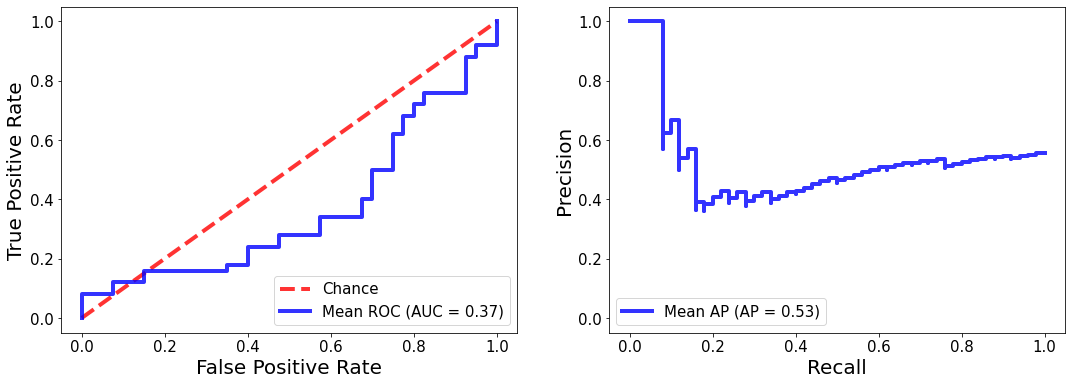

In [39]:
plot_au_curves(test_cv_results)

In [40]:
calculate_cv_results(test_cv_results)

,Fold,Accuracy,Precision,Recall,F1-Score,MCC
0,Fold 0,0.555556,0.6,0.6,0.600000,0.10
1,Fold 1,0.111111,0.2,0.2,0.200000,-0.80
2,Fold 2,0.333333,0.4,0.4,0.400000,-0.35
3,Fold 3,0.333333,0.4,0.4,0.400000,-0.35
4,Fold 4,0.333333,0.4,0.4,0.400000,-0.35
5,Fold 5,0.333333,0.4,0.4,0.400000,-0.35
6,Fold 6,0.555556,0.6,0.6,0.600000,0.10
7,Fold 7,0.444444,0.5,0.4,0.444444,-0.10
8,Fold 8,0.333333,0.4,0.4,0.400000,-0.35
9,Fold 9,0.333333,0.4,0.4,0.400000,-0.35
